In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

data=pd.read_csv("chicago-building-violations/building-violations.csv")

plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif']=['SimHei']

# 1.对标称属性统计每个可能取值的频数

In [3]:
data['VIOLATION STATUS'].value_counts()

OPEN        999892
COMPLIED    600873
NO ENTRY      5376
Name: VIOLATION STATUS, dtype: int64

In [4]:
data['INSPECTION STATUS'].value_counts()

FAILED    1116648
PASSED     275909
CLOSED     213464
HOLD          104
Name: INSPECTION STATUS, dtype: int64

In [5]:
data['INSPECTION CATEGORY'].value_counts()

COMPLAINT       1135325
PERIODIC         400487
PERMIT            67735
REGISTRATION       2594
Name: INSPECTION CATEGORY, dtype: int64

In [6]:
data['DEPARTMENT BUREAU'].value_counts()

CONSERVATION                  1070068
DEMOLITION                     120009
SPECIAL TASK FORCE             108158
ELEVATOR                        80190
ELECTRICAL                      35947
BOILER                          29867
VENTILATION                     29834
REFRIGERATION                   29230
NEW CONSTRUCTION                27688
PLUMBING                        26778
SPECIAL INSPECTION PROGRAM      19734
IRON                            14309
SIGNS                           13079
WATER                             784
CONSTRUCTION EQUIPMENT            466
Name: DEPARTMENT BUREAU, dtype: int64

In [7]:
data['STREET DIRECTION'].value_counts()

S    652948
W    479503
N    380237
E     93453
Name: STREET DIRECTION, dtype: int64

# 2.对数值属性求最大/最小/均值/中位数/四分位数/缺失值个数

In [8]:
num_data=data[['ID','INSPECTION NUMBER','STREET NUMBER','LATITUDE', 'LONGITUDE']]
num_data.describe()

,ID,INSPECTION NUMBER,STREET NUMBER,LATITUDE,LONGITUDE
count,1.606141e+06,1.606141e+06,1.606141e+06,1.604691e+06,1.604691e+06
mean,3.934830e+06,7.835725e+06,4.147647e+03,4.184605e+01,-8.767282e+01
std,1.449792e+06,4.538310e+06,2.890586e+03,8.749916e-02,5.750284e-02
min,2.199700e+05,2.655750e+05,1.000000e+00,4.164467e+01,-8.791444e+01
25%,2.684481e+06,2.263922e+06,1.648000e+03,4.177123e+01,-8.771395e+01
50%,4.079898e+06,1.034090e+07,3.744000e+03,4.185425e+01,-8.767003e+01
75%,5.181752e+06,1.161002e+07,6.225000e+03,4.191435e+01,-8.763318e+01
max,6.214219e+06,1.285384e+07,1.377000e+04,4.202269e+01,-8.752468e+01


In [9]:
print("-----缺失值列表-----")
print("ID:",data['ID'].isnull().sum())
print("INSPECTION NUMBER:",data['INSPECTION NUMBER'].isnull().sum())
print("STREET NUMBER:",data['STREET NUMBER'].isnull().sum())
print("LATITUDE:",data['LATITUDE'].isnull().sum())
print("LONGITUDE:",data['LONGITUDE'].isnull().sum())

-----缺失值列表-----
ID: 0
INSPECTION NUMBER: 0
STREET NUMBER: 0
LATITUDE: 1450
LONGITUDE: 1450


# 3.对数值属性绘制直方图/QQ图/盒图

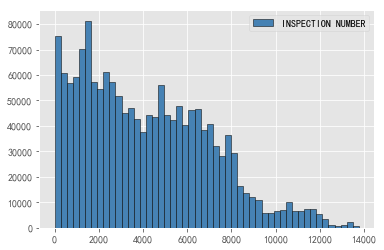

In [10]:
plt.hist(data['STREET NUMBER'],bins = 50,color = 'steelblue',edgecolor = 'k',label = 'INSPECTION NUMBER')
plt.legend()
plt.show()

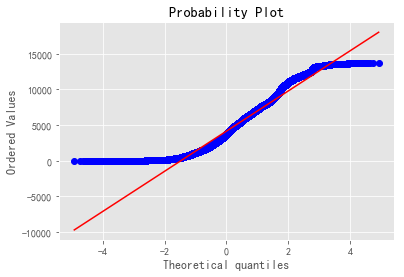

In [11]:
stats.probplot(data['STREET NUMBER'],dist="norm",plot=plt)
plt.show()

### 根据上方QQ图可知，数值属性STREET NUMBER服从正太分布；根据下面的盒图可以看出，属性STREET NUMBER存在若干数值较大的离群值

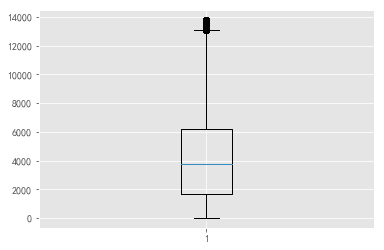

In [12]:
plt.boxplot(data[ 'STREET NUMBER'])
plt.show()

# 4.处理属性LATITUDE的缺失值

## 4.1将缺失部分剔除

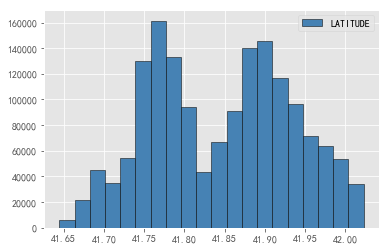

In [13]:
drop_data1=data.dropna(subset=['LATITUDE'])
plt.hist(drop_data1['LATITUDE'],bins = 20,color = 'steelblue',edgecolor = 'k',label = 'LATITUDE')
plt.legend()
plt.show()

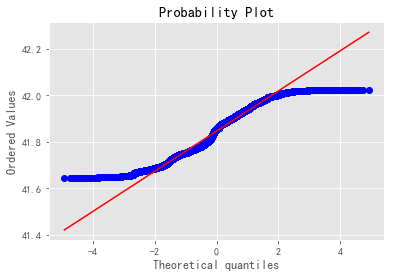

In [14]:
stats.probplot(drop_data1['LATITUDE'],dist="norm",plot=plt)
plt.show()

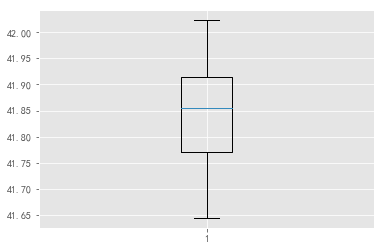

In [15]:
plt.boxplot(drop_data1[ 'LATITUDE'])
plt.show()

## 4.2用最高频率值来填补缺失值

### 由于观测值都较好地聚集在平均值周围，所以选择均值代替缺失值

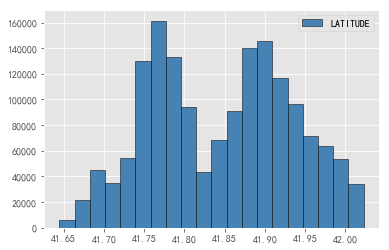

In [16]:
fill_mean_data1=data['LATITUDE'].fillna(data['LATITUDE'].mean())
plt.hist(fill_mean_data1,bins = 20,color = 'steelblue',edgecolor = 'k',label = 'LATITUDE')
plt.legend()
plt.show()

## 4.3 通过属性的相关关系来填补缺失值

### 把属性LATITUDE缺失值作为新的label，建立模型得到预测值，然后进行填充，这里采用随机森林RF进行拟合。

In [21]:
from sklearn.ensemble import RandomForestRegressor

data1=data.copy(deep=True)
lat_data=data[['LATITUDE','INSPECTION NUMBER','STREET NUMBER','PROPERTY GROUP']]
known_lat = lat_data[lat_data['LATITUDE'].notnull()].values
unknown_lat = lat_data[lat_data['LATITUDE'].isnull()].values
y = known_lat[:, 0]
X = known_lat[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rfr.fit(X, y)
predictedLat = rfr.predict(unknown_lat[:, 1:])
data.loc[(data['LATITUDE'].isnull()), 'LATITUDE' ] = predictedLat
data['LATITUDE'].isnull().sum()

0

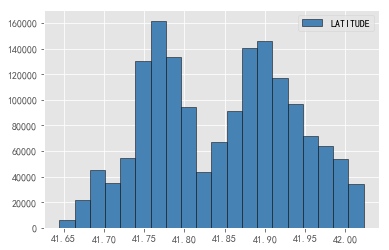

In [19]:
plt.hist(lat_data['LATITUDE'],bins = 20,color = 'steelblue',edgecolor = 'k',label = 'LATITUDE')
plt.legend()
plt.show()

## 4.4通过数据对象之间的相似性来填补缺失值

### 填充近邻的数据，先利用knn计算临近的k个数据，然后填充他们的均值。

In [ ]:
from fancyimpute import KNN
data_knn=np.array(data1[['LATITUDE','INSPECTION NUMBER','STREET NUMBER','PROPERTY GROUP']])
fill_knn_data=pd.DataFrame(KNN(k=3).fit_transform(data_knn))